In [7]:
# Import Dependencies

from time import sleep
from mido import MidiFile
import pandas as pd

from datetime import date
from time import time, monotonic
from os import path, mkdir, listdir, environ
import subprocess


In [8]:
# Get Args, define evaluation groups

iterations = 1        # How many times each experiment should be repeated for the same parameters?
min_input_bars = 1    # What is the minimum lookback size for each model?
min_output_bars = 1   # What is the minimum output size for each model?

max_input_bars = 1    # What is the maximum lookback size for each model?
max_output_bars = 1   # What is the maximum output size for each model?
# sample_length = 32  # How long of a final composition should be generated?
sample_length = 8     # How long of a final composition should be generated?
ignore = ['music_transformer']  # What models to ignore during generation/analysis

modelname = None
checkpointname = None


# Evaluated Model Table
eval_columns = (
    ['model'               , 'dataset'       , 'checkpoint']
)
eval_list = (
  [ ['performance_rnn'     , 'piano-e-comp'  , 'performance_with_dynamics']
  , ['performance_rnn'     , 'piano-e-comp'  , 'density_conditioned_performance_with_dynamics']
  , ['performance_rnn'     , 'piano-e-comp'  , 'pitch_conditioned_performance_with_dynamics']
  , ['performance_rnn'     , 'piano-e-comp'  , 'multiconditioned_performance_with_dynamics']
  , ['performance_rnn'     , 'piano-e-comp'  , 'performance_with_dynamics_and_modulo_encoding']
  , ['rl_duet'             , 'bach10'        , 'rl_duet']
  , ['pianoroll_rnn_nade'  , 'bach10'        , 'rnn-nade_attn']
  , ['melody_rnn'          , 'bach10'        , 'basic_rnn']
  , ['melody_rnn'          , 'bach10'        , 'mono_rnn']
  , ['melody_rnn'          , 'bach10'        , 'attention_rnn']
  , ['melody_rnn'          , 'bach10'        , 'lookback_rnn']
  , ['polyphony_rnn'       , 'bach10'        , 'polyphony_rnn']
  , ['pianoroll_rnn_nade'  , 'bach10'        , 'rnn-nade_attn']
  , ['music_transformer'   , 'piano-e-comp'  , 'performance_with_dynamics']
  ]
)
eval_list = pd.DataFrame(eval_list, columns=eval_columns)

# Filter ignored models
for ignored_model in ignore:
  eval_list = eval_list[eval_list['model'] != ignored_model]

# Index table with dataset names
evaluation_sets = [
  (dataset, [ (modelname, checkpoint)
    for [modelname, checkpoint]
    in inner_df[['model', 'checkpoint']].values 
  ])
  for dataset, inner_df in eval_list.groupby(['dataset'])
]

cols_gen = [ "model", "checkpoint", "dataset", "primer", "iteration", "out_file", "time", "in_len", "out_len" ]

In [9]:
# Folder Definitions (+ Create new folder)
outputdir = path.join(path.curdir,'output')
datasetdir = path.join(path.curdir,'dataset')
basefoldername = str(date.today())
i = 0
while True:
    foldername = f'{basefoldername}-{i}'
    full_foldername = path.join(outputdir, foldername)

    if not path.exists(full_foldername):
      mkdir(full_foldername)
      break

    if not any(listdir(full_foldername)): break
    i = i + 1

expname = ''
def log(message):
    print(f'[batch:{expname}] {message}')

In [10]:
# Generation Methods

from functools import reduce
import re

# Prepare a command string to send to ornette via CLI
def escape_command(commands):
  commands = re.split('\n|;', commands)
  commands = [line.split(' ') for line in commands]
  commands = ['\ '.join(line) for line in commands]
  commands = '\;'.join(commands)
  return commands

def get_filename(modelname, checkpointname, primer, index, bars_input, bars_output):
  return f'{foldername}/{modelname}-{checkpointname}-{index}-{bars_input}-{bars_output}-{primer}'

# WIP: another approach, via CLI args
def get_generation_command(the_modelname, the_checkpointname, datapath, primer, bars_input, bars_output, count):
  
  # Main generation loop
  exec_cmd = ';\n'.join([f'generate {bars_output} bars'
      for i in range(1000) # FIXME: This can be better calculated
      if i * bars_output < sample_length])

  # Reset, load the primer again, generate, save
  exec_cmd = ['\n;'.join(
      [ 'reset;'
      , f'load {datapath}/{primer} {bars_input}'
      , exec_cmd
      , f'save {get_filename(the_modelname, the_checkpointname, primer, index, bars_input, bars_output)}'
      , 'end'
      ]
    )
    for index
    in range(count)]
  
  # Before running generation: set variables
  exec_cmd = '\n'.join(
    [ 'set debug_output True;'
    , 'set batch_mode True;'
    , 'set playback False;'
    , 'set trigger_generate 1;'
    , 'set batch_unit measures;'
    , 'set debug_output False;'
  ] + exec_cmd)

  # Escape string to pass it via CLI
  exec_cmd = escape_command(exec_cmd)
  return exec_cmd


logfile = None
def generate_samples(the_modelname, the_checkpointname, datapath, primer, bars_input, bars_output, count):

    # Set logging prefix
    modelname = the_modelname
    checkpointname = the_checkpointname
    log(f'Generating ({modelname}:{checkpointname}) samples with {primer}')

    # Get Ornette CLI command
    if datapath.startswith('.'): datapath = datapath[1:]
    cmd = get_generation_command(the_modelname, the_checkpointname, datapath, primer, bars_input, bars_output, count)
    # print(cmd.split(';')[-1])
    # print('\n'.join(cmd.split(';')))

    # Process filenames
    filenames = [get_filename(the_modelname, the_checkpointname, primer, index, bars_input, bars_output) for index in range(count)]
    log(filenames)


    # Run (and time) the generation batch
    env = environ.copy()
    logfile = open(path.join(outputdir, f'{the_modelname}.log'), 'w')

    start_time = monotonic()
    server = subprocess.run(
        ['python'
        , '.'
        , '--modelname'
        , modelname
        , '--checkpoint'
        , checkpoint
        , '--exec'
        , cmd
        ]
      , env=env
      , stdout=logfile
      , stderr=logfile
      # , stdout=subprocess.PIPE
      )
    # server.communicate()
    if server.stdout: print(server.stdout.strip().decode('utf-8'))
    if server.stderr: print(server.stderr.strip().decode('utf-8'))
    end_time = monotonic()
    
    # Calculate total generation time
    gentime = end_time - start_time
    return [(filenames, gentime)]

def run_generation(model, checkpoint, datapath, primers):
  
  # filenames, gentime = generate_samples(model, checkpoint, datapath, primer, bars_input, bars_output, iterations)
  return [
    [ model
    , checkpoint
    , dataset
    , primer
    , iterations # TODO: pass iterations to generate samples / use iterations here
    # , *generate_samples(model, checkpoint, datapath, primer, bars_input, bars_output, iterations)
    , filename
    , gentime
    , bars_input
    , bars_output
    ]
    for bars_input in range(min_input_bars,max_input_bars + 1)
    for bars_output in range(min_output_bars,max_output_bars + 1)
    for primer in primers
    for (filenames, gentime) in generate_samples(model, checkpoint, datapath, primer, bars_input, bars_output, iterations)
    for filename in filenames
  ]


In [11]:
# Generation Phase

import pickle

max_primers = None
max_primers = 5

try:
    log(f'Starting experiment suite: {outputdir}/{foldername}')

    # Set logging prefix

    output = []
    for dataset, models in evaluation_sets:
        if dataset is None: continue
        datapath = path.join(datasetdir, dataset)
        primerdir = datapath
        if not path.exists(datapath):
            print(f'Directory not found: {datapath}, skipping')
            continue

        primers = listdir(datapath)
        if max_primers: primers = primers[:max_primers]

        for (model, checkpoint) in models:
            expname = model
            # start_model(model, checkpoint)

            e = run_generation(model, checkpoint, datapath, primers)

            output += e
    print(output)
    # Save temp file
    # with open('output/output.tmp', 'wb') as f:
    #   pickle.dump(output, f)
    
    # Create DataFrame
    df = pd.DataFrame(output, columns=cols_gen)
    print(df.describe())
    df.to_pickle(path.join(outputdir, 'df_gen'))
    

except KeyboardInterrupt:
  print("Terminating...")

print("Done!")

-02-0/performance_rnn-pitch_conditioned_performance_with_dynamics-0-1-1-MIDI-Unprocessed_XP_20_R2_2004_01_ORIG_MID--AUDIO_20_R1_2004_01_Track01_wav.midi']
[batch:performance_rnn] Generating (performance_rnn:pitch_conditioned_performance_with_dynamics) samples with MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_05_Track05_wav.midi
[batch:performance_rnn] ['2021-08-02-0/performance_rnn-pitch_conditioned_performance_with_dynamics-0-1-1-MIDI-Unprocessed_24_R1_2006_01-05_ORIG_MID--AUDIO_24_R1_2006_05_Track05_wav.midi']
[batch:performance_rnn] Generating (performance_rnn:pitch_conditioned_performance_with_dynamics) samples with ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--4.midi
[batch:performance_rnn] ['2021-08-02-0/performance_rnn-pitch_conditioned_performance_with_dynamics-0-1-1-ORIG-MIDI_01_7_7_13_Group__MID--AUDIO_12_R1_2013_wav--4.midi']
[batch:performance_rnn] Generating (performance_rnn:multiconditioned_performance_with_dynamics) samples with MIDI-Unprocessed_R

In [12]:
# Filter Data
import pandas as pd
df_gen = pd.read_pickle('output/df_gen')

# Get Models
def get_models(df_):
    df_['uniquename'] = df_['model'] + ':' + df_['checkpoint']
    uniques = [x for x in df_['uniquename'].unique()]
    return uniques

# Only where an output file exists
df_success = df_gen[df_gen.apply(lambda x: os.path.exists(f'output/{x["out_file"]}.mid'),axis=1)]

# print(newdf)
err = [name for name
  in get_models(df_gen)
  if name not in get_models(df_success)]

if any(err):
    df_success.to_pickle(path.join(outputdir, 'df_gen'))
    print(f'The following models had problems at generation time and will not be analysed: {", ".join(err)}')
else:
  print("DataFrame checked!")

DataFrame checked!


In [13]:
# Analysis Stage

import os
import subprocess
import glob
import json
import pandas as pd
from tqdm import tqdm
outputdir = os.path.abspath(os.path.join(os.curdir, 'output'))
df_gen = pd.read_pickle(os.path.join(outputdir, 'df_gen'))
metricsfile = os.path.join(outputdir, 'metrics')

output_samples_dir  = os.path.join(outputdir, 'samples')
output_dataset_dir  = os.path.join(outputdir, 'dataset')

# Define External Commands
extraction_scriptdir = os.path.abspath(os.path.join(os.path.pardir, 'mgeval'))
extraction_script = os.path.join(extraction_scriptdir, 'start.sh') 
cmd_extraction = [ 'bash', extraction_script, output_samples_dir, output_dataset_dir, metricsfile, str(sample_length) ]

preprocess_scriptdir = os.path.abspath(os.path.join(os.path.pardir, 'miditools'))
preprocess_script = os.path.join(preprocess_scriptdir, 'midisox_py')
cmd_preprocess = lambda _in, _out: [ 'python', preprocess_script, '-m', os.path.abspath(_in), os.path.abspath(_out) ]

# Prepare output log file
logfile = open(path.join(outputdir, f'analysis.log'), 'w')

# Prepare Metrics DF
df_metrics = df_gen

# Prepare Output Data Fields
metriccolumns = ['model', 'in_len', 'out_len', 'iteration']
metrics_initialized = False
out = []


datadirs = [ output_samples_dir, output_dataset_dir ]

# Iterate combinations of input/output windows
grouping = df_metrics.groupby(['model', 'in_len', 'out_len', 'dataset', 'iteration'])
t = tqdm(grouping.out_file)
for (model, inn, outn, dataset, iteration), outfiles in t:
    expname = model
    t.set_description(model)

    for _dir in datadirs:
        # Check that directory exists
        if not os.path.exists(_dir):
            os.mkdir(_dir)

        # Clean output directory
        for file in glob.glob(os.path.join(_dir,'*')):
            # log(f'removing: {file}')
            if not os.path.exists(file): continue
            if os.path.islink(file): os.unlink(file)
            else: os.remove(file)

    # Remove previous metrics file if any (for sanity)
    if os.path.exists(metricsfile):
        os.remove(metricsfile)

    # Prepare Baseline Dataset Samples
    dataset_samples = glob.glob(os.path.join(os.path.curdir, 'dataset', dataset, '*'))
    
    # FIXME
    dataset_samples = dataset_samples[:len(outfiles.unique())]
    for index, filename in enumerate(dataset_samples):
        out_filename = os.path.join(outputdir, 'dataset', f'sample-{index}.mid')
        subprocess.call(cmd_preprocess(filename, out_filename), stdout=logfile, stderr=logfile, cwd=preprocess_scriptdir)
    
    # Prepare Output Samples 
    for o, outfile in enumerate(outfiles.unique()):

        # Create link to file
        in_filename = os.path.abspath(os.path.join("output", f"{outfile}.mid"))
        out_filename = os.path.abspath(os.path.join(output_samples_dir, f'sample-{o}.mid'))
        # log(f'creating: {file}')
        # log('processing: ' + ' '.join(cmd_preprocess(in_filename, out_filename)))
        # log(f'({inn} | {outn} bars) processing file: {in_filename} -> {out_filename}')
        subprocess.call(cmd_preprocess(in_filename, out_filename), stdout=logfile, stderr=logfile, cwd=preprocess_scriptdir)

    # Extract Features
    subprocess.call(cmd_extraction, stdout=logfile, stderr=logfile, cwd=extraction_scriptdir)

    # Read Extracted features
    with open(metricsfile, 'r') as metricsfile_:
        row_metrics = json.load(metricsfile_)

    # Initialize Metrics (if necessary)
    if not metrics_initialized:
        metrics_initialized = True
        for metric in row_metrics.keys():
            metriccolumns.extend([metric + '_kl_div', metric + '_overlap'])
    

    row = [model, inn, outn, iteration]
    # print(row_metrics)
    for metric in row_metrics.keys():
        [_mean, _std, _kl_div, _overlap, _training_set_kl_div, _training_set_overlap] = row_metrics[metric]
        row.extend([ _kl_div, _overlap ])
    out.append(row.copy())

logfile.close()

# Save values to output DF
print(pd.DataFrame(out, columns=metriccolumns))
df = df_metrics.merge(pd.DataFrame(out, columns=metriccolumns), how='inner', on=['model', 'in_len', 'out_len', 'iteration'])

df.to_pickle(path.join(outputdir, 'df_metrics'))

rl_duet: 100%|██████████| 5/5 [01:42<00:00, 20.52s/it]                model  in_len  out_len  iteration  \
0          melody_rnn       1        1          1   
1     performance_rnn       1        1          1   
2  pianoroll_rnn_nade       1        1          1   
3       polyphony_rnn       1        1          1   
4             rl_duet       1        1          1   

   bar_pitch_class_histogram_kl_div  bar_pitch_class_histogram_overlap  \
0                          0.883171                           0.715157   
1                          0.608409                           0.782532   
2                          0.464188                           0.824892   
3                          0.545193                           0.821358   
4                          0.375777                           0.751242   

   bar_used_pitch_kl_div  bar_used_pitch_overlap  total_used_note_kl_div  \
0               0.069024                0.002471                0.124213   
1               0.051611      

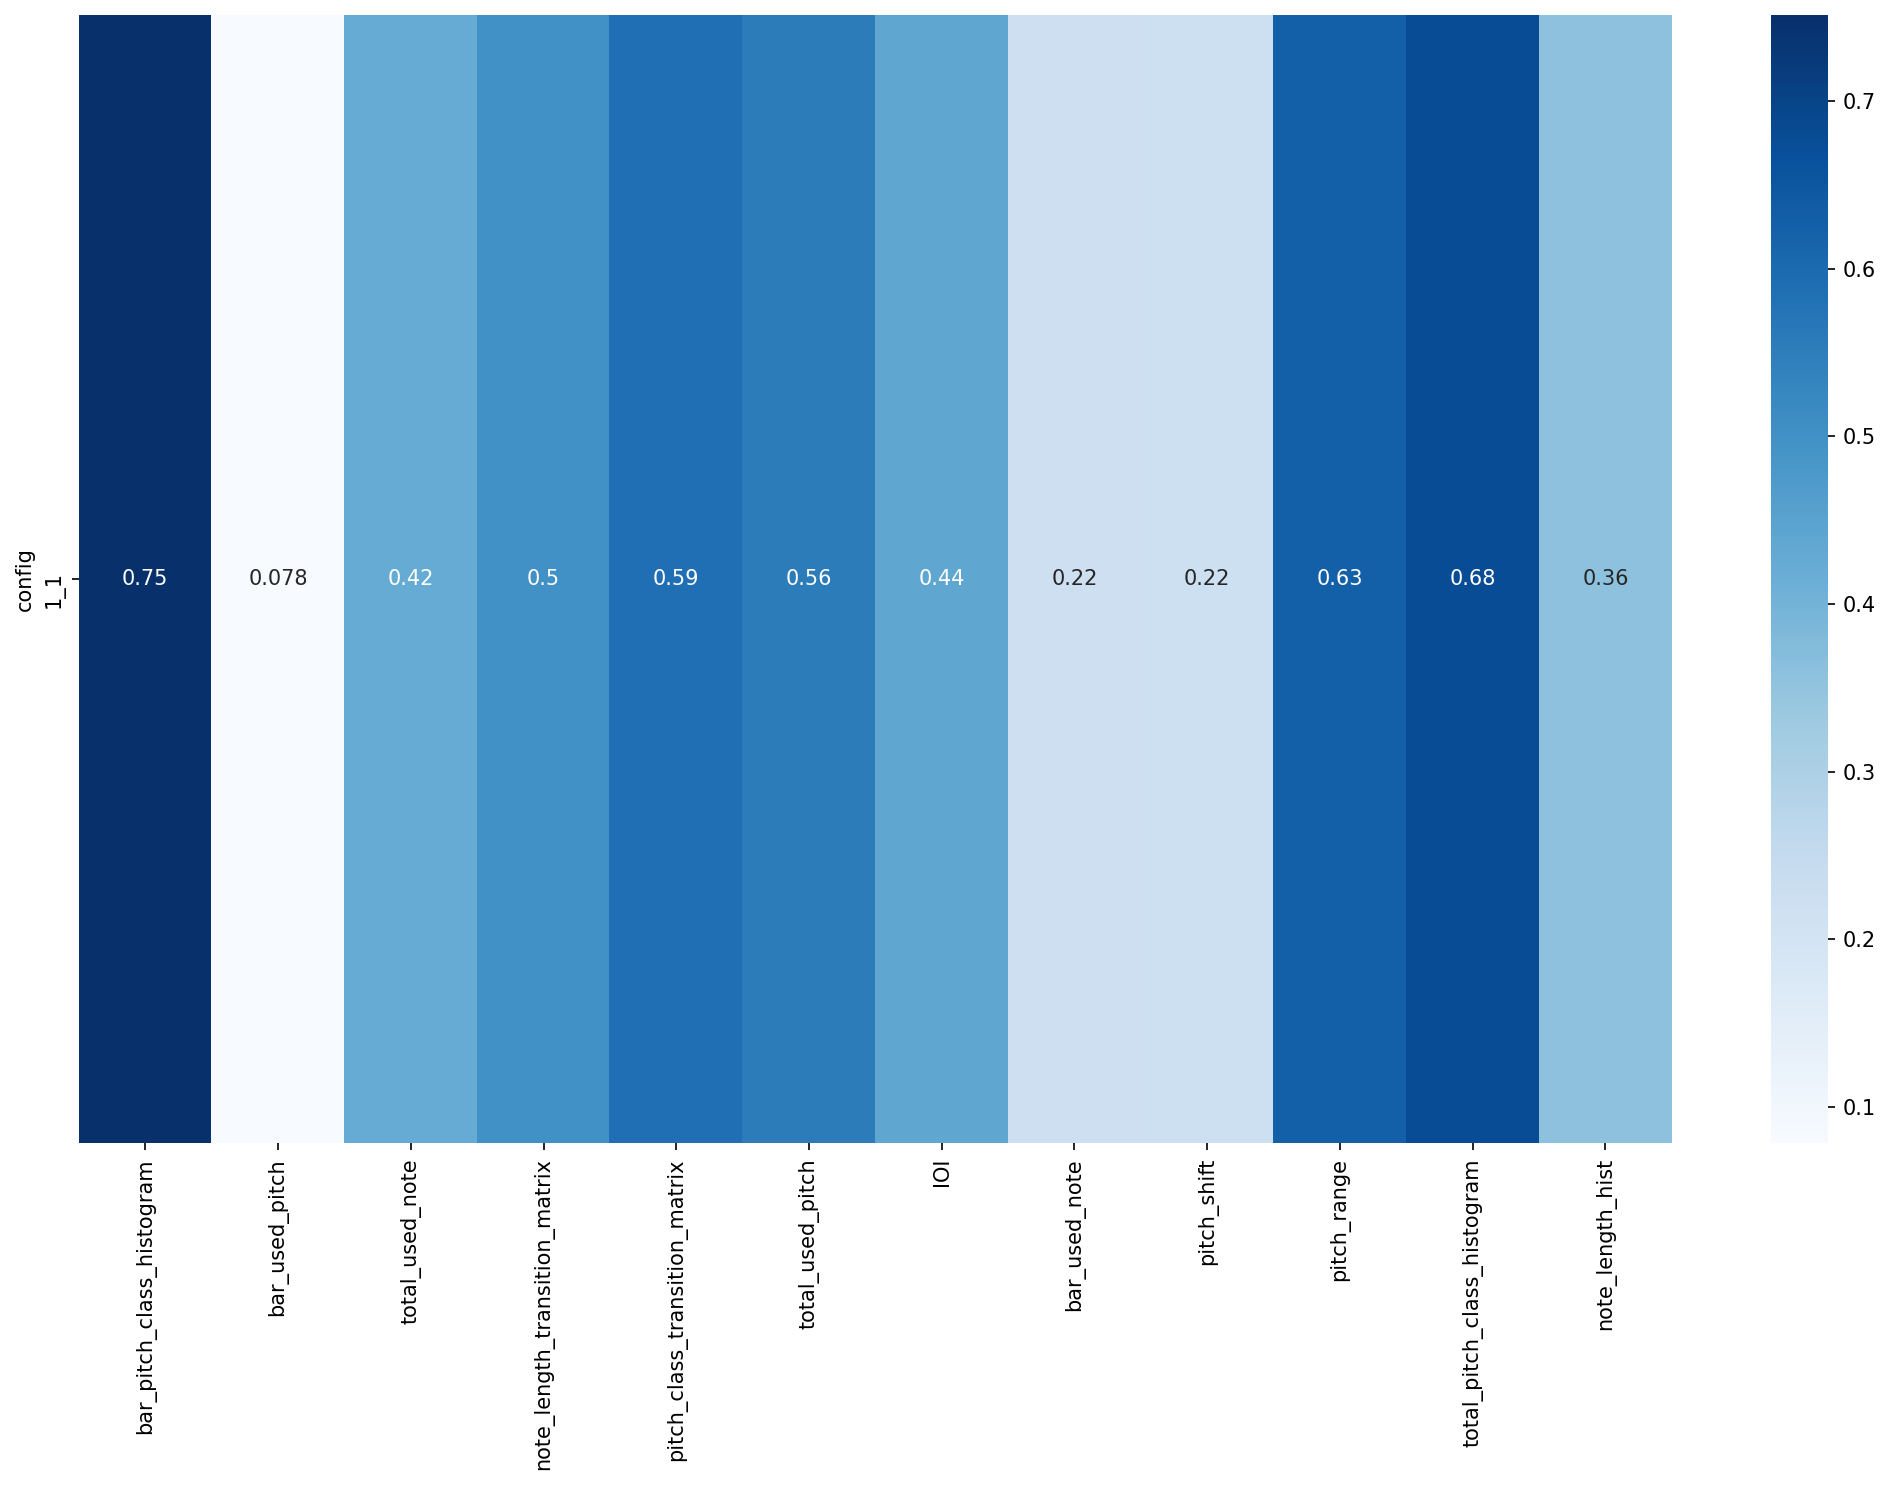

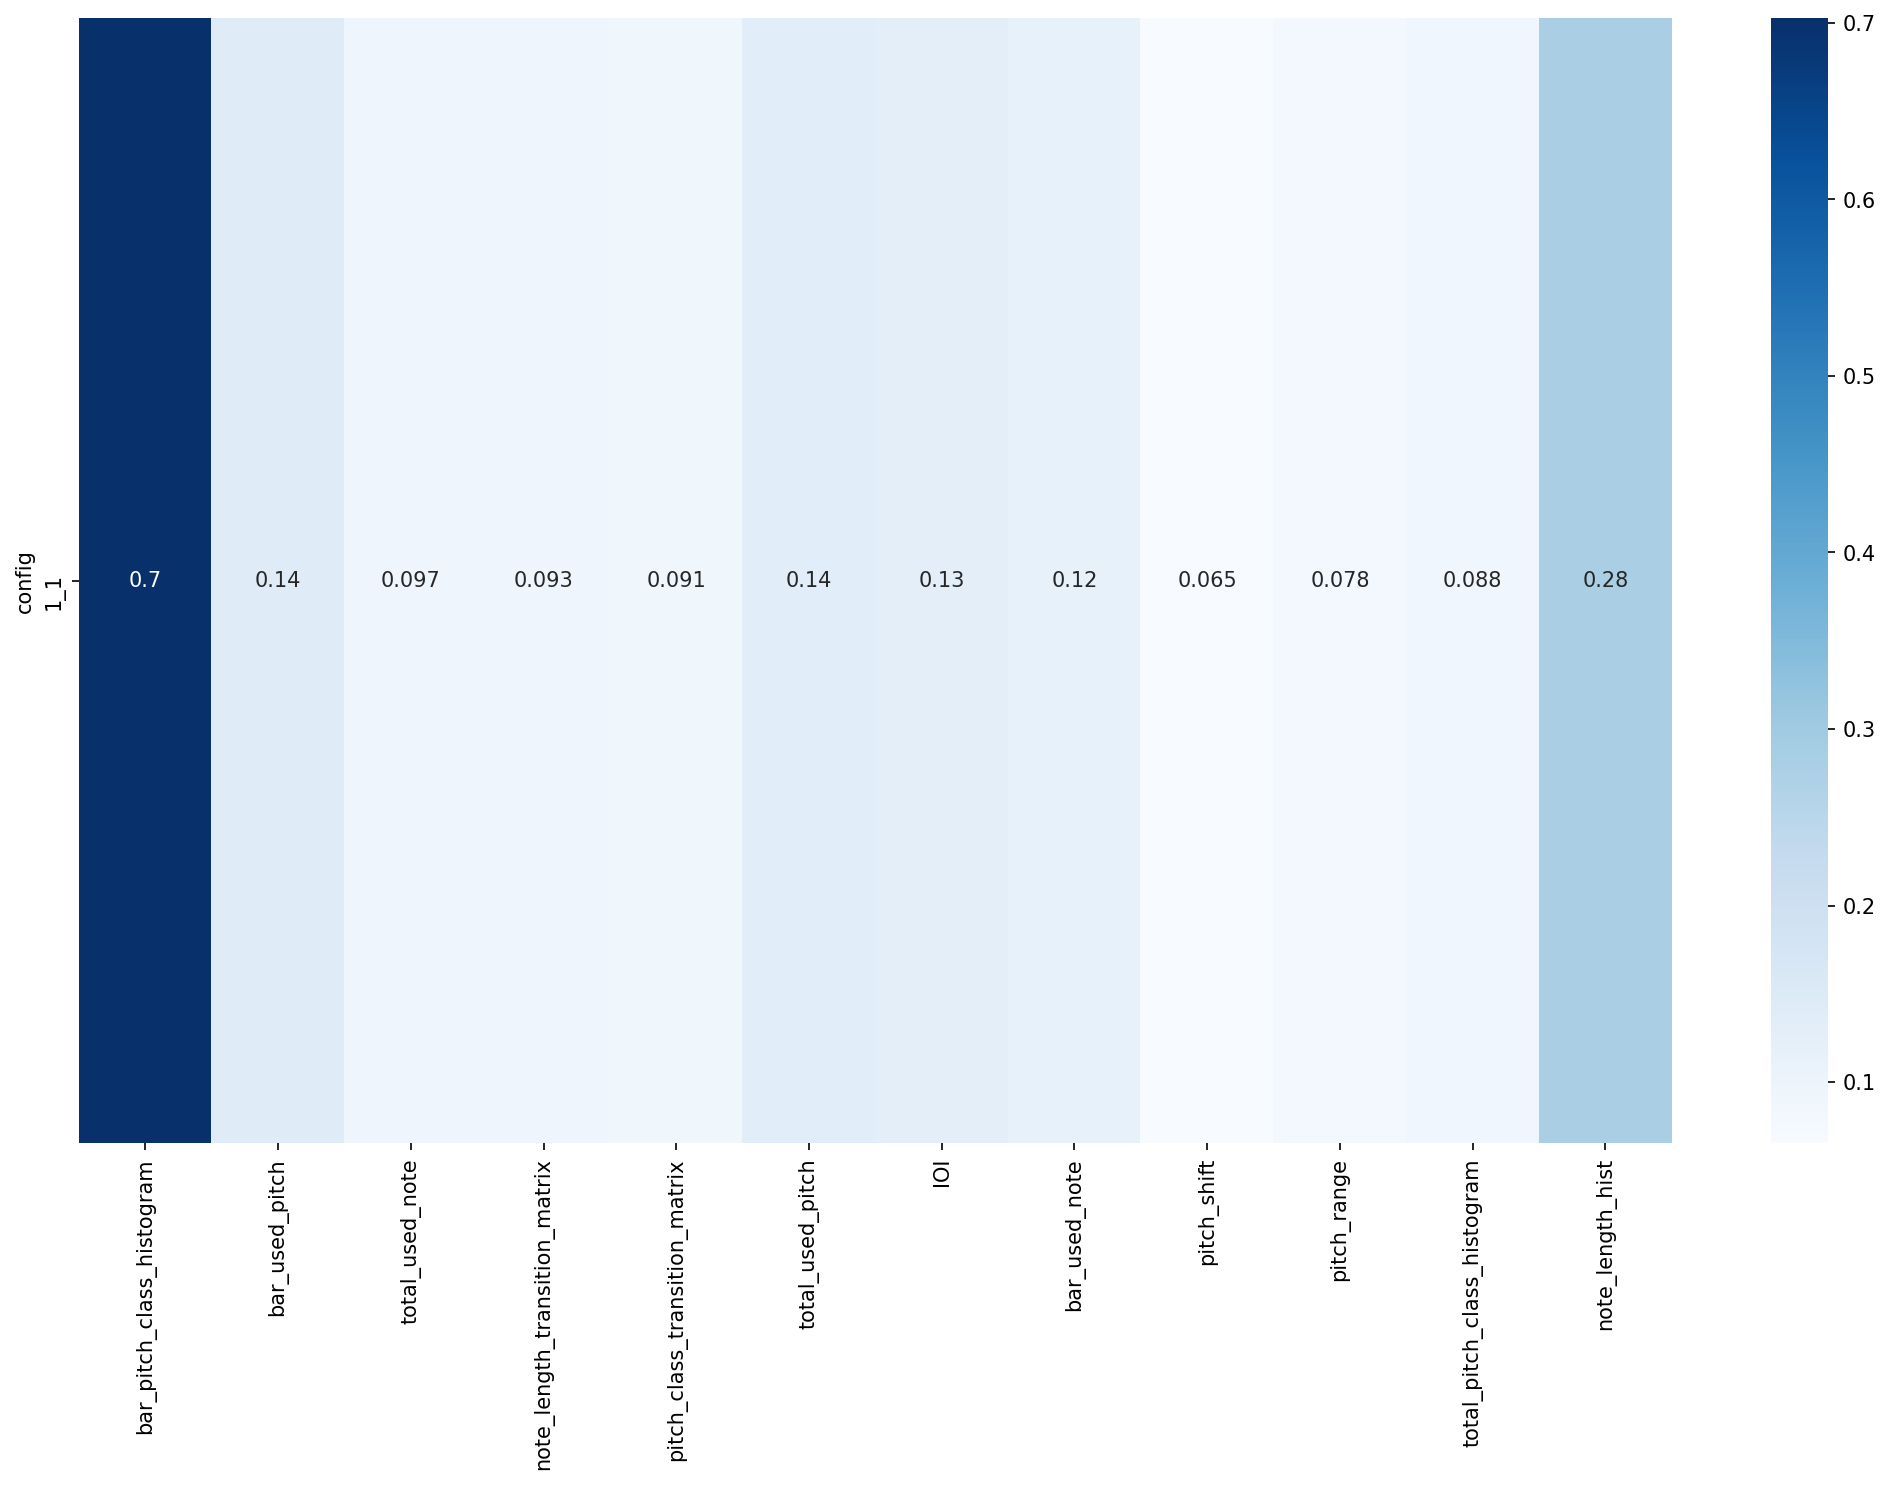

<Figure size 1200x900 with 0 Axes>

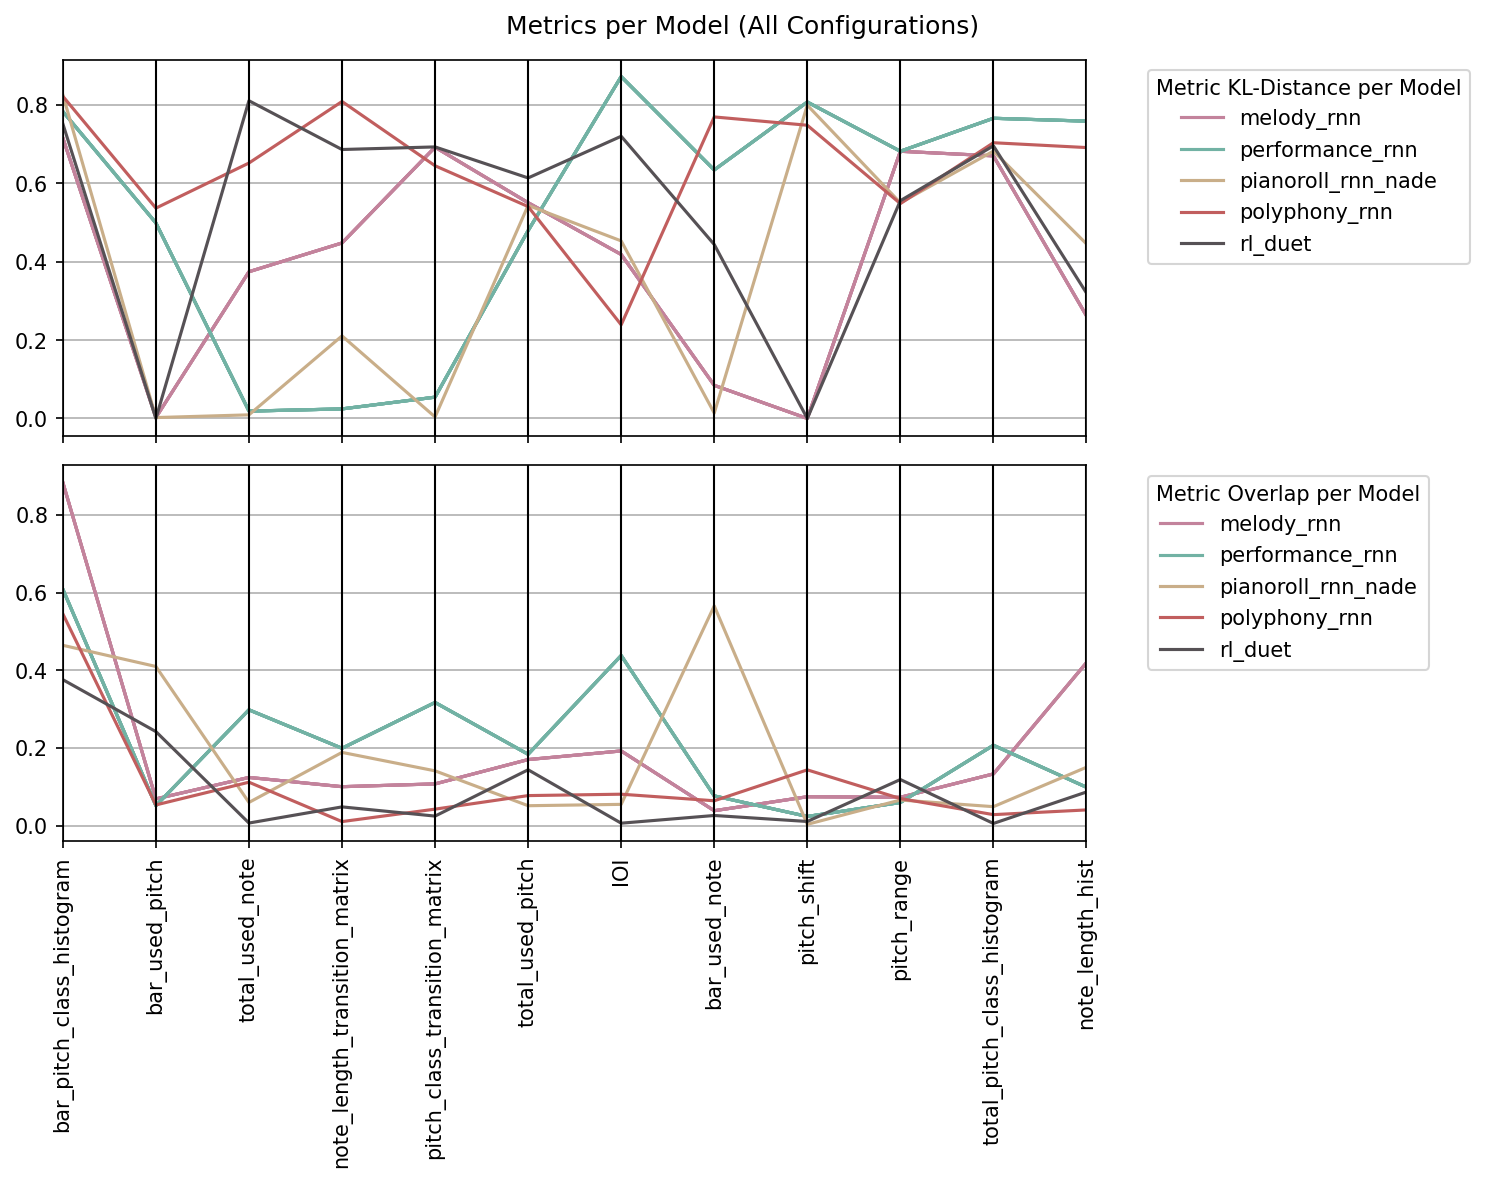

<Figure size 1200x900 with 0 Axes>

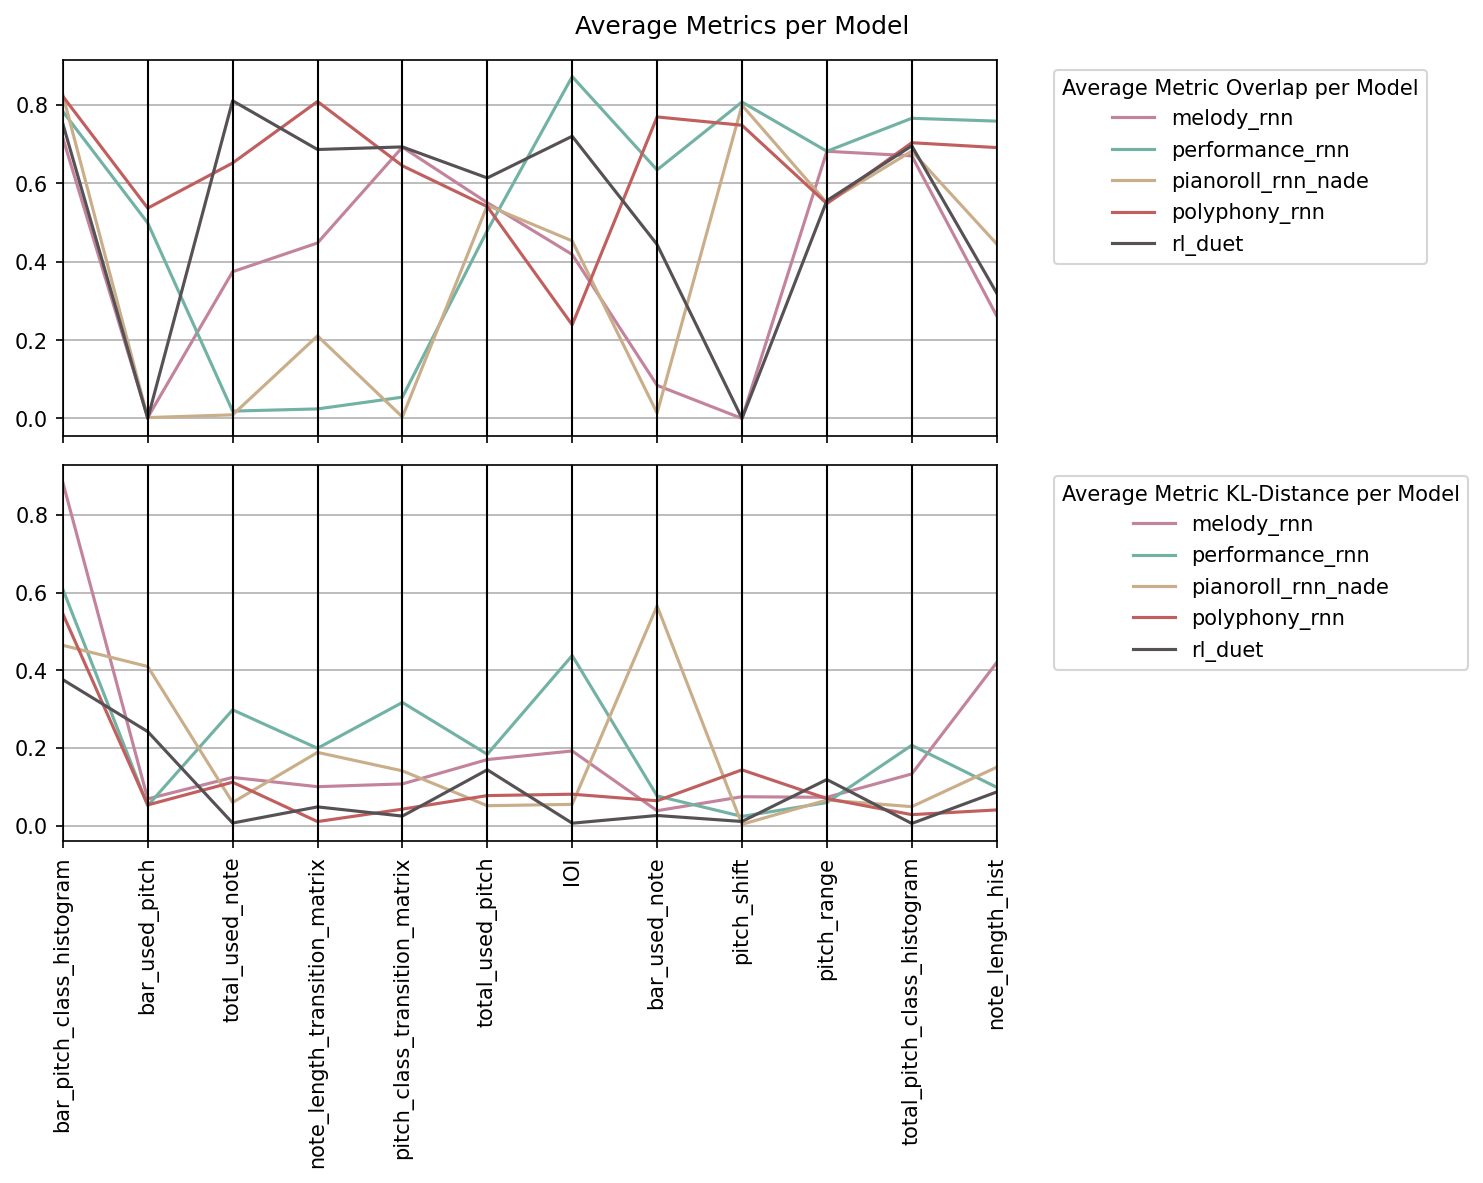


Done! Generated plots: [None, 'time_per_length_shared', 'parallel_coordinates_all_configs', 'parallel_coordinates_average', 'parallel_coordinates_best_of_each', 'heatmap_metric_per_config']


In [30]:
# Plotting phase

import matplotlib.pyplot as plt
import seaborn as sns
import math

suffix = '_avg'
make_heat_maps = True
make_kldiv_plots = True
make_overlap_plots = True
make_time_plots = True
# Read DF
df = pd.read_pickle(path.join(outputdir, 'df_metrics'))
# df = pd.read_pickle(path.join(outputdir, 'df_metrics_performance_rnn'))

# Calculate Mean Values for each in/out len combination
df = df.drop(['out_file', 'primer', 'iteration'], axis=1)
df = df.groupby(['model', 'checkpoint', 'dataset', 'in_len', 'out_len']).mean()
df = df.add_suffix(suffix).reset_index()

# Create Fig Folder
figdir = 'figs'
if not os.path.exists(figdir):
    os.mkdir(figdir)

# Define which plots to make
plots_to_make = (
    [ None
    # , 'time_heatmap_per_model'
    # , 'kldiv_per_model'
    # , 'overlap_per_model'
    # , 'time_per_length'
    # , 'time_ratio_per_length'
    # , 'time_per_length_shared' # TODO: Before doing this, check if there's a correlation
    , 'time_per_length_shared'
    , 'parallel_coordinates_all_configs'
    , 'parallel_coordinates_average'
    , 'parallel_coordinates_best_of_each'
    , 'heatmap_metric_per_config'
    ]
)


# Get in/out len dimensions
max_in = max(df['in_len'])
max_out = max(df['out_len'])

# Get Evaluation Metric Names
eval_metrics = ['time' + suffix] + [c for c in list(df.columns) if c.endswith('overlap' + suffix) or c.endswith('kl_div' + suffix)]

overlaps = [m for m in eval_metrics if m.endswith('overlap' + suffix)]
kl_divs  = [m for m in eval_metrics if m.endswith('kl_div' + suffix)]

# Iterate model-checkpoint-dataset tuples
grouping = df.groupby(['model', 'checkpoint', 'dataset'])


# HeatMaps
for (model, checkpoint, dataset), inner_df in grouping:
    # inner_df = inner_df.groupby(['in_len', 'out_len'])
    if 'time_heatmap_per_model' not in plots_to_make: break
    for metric in eval_metrics[:1]:
    # for metric in eval_metrics:
        mdf = inner_df[['in_len', 'out_len', metric]]
        mdf = pd.pivot_table(mdf, values=metric, index=['in_len'], columns=['out_len'], fill_value=0)
        plt.figure()
        plt.title(f'{metric} - {model} {checkpoint} {dataset}')
        # print(sns.heatmap(mdf, cmap='RdYlGn_r', linewidths=0.5, annot=True))
        sns.heatmap(mdf, cmap='RdYlGn_r', linewidths=0.5, annot=True)
        #plt.pcolor(mdf)
        #plt.title(metric)
        
        plt.savefig(f'{figdir}/time-heatmap-{"-".join([model, checkpoint, dataset])}')



# make_line_plots
plot_sets =[
    ('Average Overlaps with Base Dataset', overlaps, 'overlaps'),
    ('Average KL-Divergence against Base Dataset', kl_divs, 'kl_divs'),
    # ('Average Generation Time', ['time_avg'])
]

# TODO: Line Plots
# How does Input Length affect each metric for a model
for (model, checkpoint, dataset), inner_df in grouping:
    if 'kldiv_per_model' not in plots_to_make: break
    in_len_plot = inner_df.loc[inner_df['out_len'] == max(inner_df['out_len'])]
    x = 'in_len'
    if not make_kldiv_plots: continue
    for title, cols, setname in plot_sets:
        fig = plt.figure()
        # print(in_len_plot[[x] + cols])
        in_len_plot[[x] + cols].plot(x=x, colormap='jet', markersize=10)
        plt.title(model)
        plt.legend(title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig(f'{figdir}/{"-".join([setname, model, checkpoint, dataset])}', bbox_inches='tight')

for (model, checkpoint, dataset), inner_df in grouping:
    if 'overlap_per_model' not in plots_to_make: break
    out_len_plot = inner_df.loc[inner_df['in_len'] == max(inner_df['in_len'])]
    x = 'out_len'
    if not make_overlap_plots: continue    
    for title, cols, setname in plot_sets:
        plt.figure()
        # print(out_len_plot[[x] + cols])
        out_len_plot[[x] + cols].plot(x=x, colormap='jet', markersize=10)
        plt.title(model)
        plt.legend(title=title, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.savefig(f'{figdir}/{"-".join([setname, model, checkpoint, dataset])}', bbox_inches='tight')
    
# model, checkpoint

plots = ['in_len', 'out_len']
for l in plots:
    if 'metrics_per_each_len' not in plots_to_make: break
    cols = ['time_avg']
    if not make_time_plots: continue
    counterpart = [i for i in plots if i != l][0]
    for i in df[counterpart].unique():
        time_plot = df.loc[df[counterpart] == i]
        time_plot = time_plot[['model', 'checkpoint', l] + cols]
        time_plot = pd.pivot_table(time_plot, values=cols, index=[l], columns=['model', 'checkpoint'], fill_value=0)
        # print(time_plot)
        plt.figure()
        time_plot.plot()
        plt.legend(title=f'{title} ({counterpart} = {i})', bbox_to_anchor=(1.05, 1), loc='upper left')
        # plt.legend(title=f'Average Time for {counterpart} = {i}', bbox_to_anchor=(1.05, 1), loc='upper left')

# # TODO: Before doing this, check if there's a correlation
# plots = ['in_len', 'out_len']
# for l in plots:
#     if 'time_per_length_average' not in plots_to_make: break
#     cols = ['time_avg']
#     if not make_time_plots: continue
#     counterpart = [i for i in plots if i != l][0]
#     plt.figure()
#     for i in df[counterpart].unique():
#         time_plot = df.loc[df[counterpart] == i]
#         time_plot = time_plot[['model', 'checkpoint', l] + cols]
#         time_plot = pd.pivot_table(time_plot, values=cols, index=[l], columns=['model', 'checkpoint'], fill_value=0)
#         # print(time_plot)
#         time_plot.plot()
#         plt.legend(title=f'{title} ({counterpart} = {i})', bbox_to_anchor=(1.05, 1), loc='upper left')
#         # plt.legend(title=f'Average Time for {counterpart} = {i}', bbox_to_anchor=(1.05, 1), loc='upper left')


# Column names to filter out
ignore_words = ['std', 'avg', 'kl', 'div', 'overlap']
def filter_metric_names(list_):
    return ['_'.join([x for x in name.split('_') if x not in ignore_words]) for name in list_]

# PLOT: Heatmap By Configuration
from matplotlib.colors import LogNorm
if 'heatmap_metric_per_config' in plots_to_make:
    df_by_config = df.copy()
    df_by_config = df_by_config[df_by_config['model'] != 'performance_rnn']
    df_by_config['config'] = df_by_config["in_len"].astype(str) + '_' + df_by_config["out_len"].astype(str)
    configlen = len(df_by_config['config'].unique())
    df_by_config['time_avg'] = df_by_config['time_avg'] / (iterations * configlen)
    df_by_config = df_by_config.drop(columns=['in_len','out_len'])
    df_by_config = df_by_config.groupby('config')
    df_by_config = df_by_config.aggregate('mean')
    for i, metricset in enumerate([overlaps, kl_divs]):
        a = plt.figure(dpi=150,figsize=(14,10))
        inner_df = df_by_config[metricset]
        inner_df.columns = filter_metric_names(metricset)
        metricset = filter_metric_names(metricset)
        sns.heatmap(inner_df[metricset], cmap='Blues', annot=True)
        plt.tight_layout()
        plt.savefig(f'heatmap_{["overlaps","kl_divs"][i]}.png')
        plt.show()

# Parallel Coordinates Plot
from pandas.plotting import parallel_coordinates

colors = [ None
    , '#2f4b7c'
    , '#665191'
    , '#a05195'
    , '#d45087'
    , '#f95d6a'
    , '#ff7c43'
    , '#ffa600'
][1:]

colors = ["#c3839c", "#72b2a4", "#c9ae89", "#c15e5e", "#565155"]

# Make KL-Distance / Overlap Multiplot from dataframe
from pandas.plotting import parallel_coordinates
def make_kl_overlap_multiplot(dataframe,
    title="No Title",
    label_kl_divs="No KL Divs Label",
    label_overlaps="No Overlap Label"):
    metricsets = [ None
                 , (overlaps, label_overlaps)
                 , (kl_divs, label_kl_divs)
                 ][1:]

    # Create Multiplot
    a = plt.figure(dpi=150,figsize=(8,6))
    fig, axs = plt.subplots(2, dpi=150,figsize=(10,8),sharex='col', sharey='row')
    gs = fig.add_gridspec(2, 1, hspace=0, wspace=0)
    plt.suptitle(title)
    plt.xticks(rotation=90)

    

    # Create Subplots
    for i, (metricset, legend) in enumerate(metricsets):
        
        # Prepare Dataframe (Filter Columns)
        inner_df = dataframe.copy()
        subset_df = inner_df[metricset + ['model']]
        subset_df.columns = filter_metric_names(subset_df.columns)
        inner_df.columns = filter_metric_names(inner_df.columns)
        metricset = filter_metric_names(metricset)

        # Calculate plot
        final_df = pd.DataFrame(subset_df, columns=metricset)
        final_df = pd.concat([final_df, subset_df['model']], axis=1)
        # plots.append()
        parallel_coordinates(final_df, 'model', colors=colors, ax=axs[i])
        axs[i].legend(title=legend, bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()

    # plt.savefig('test.png')
    plt.show()


# Parallel Coordinates: All Configurations
if 'parallel_coordinates_all_configs' in plots_to_make:
    df_by_config = df.copy()
    make_kl_overlap_multiplot(df_by_config
    , title="Metrics per Model (All Configurations)"
    , label_overlaps="Metric KL-Distance per Model"
    , label_kl_divs="Metric Overlap per Model"
    )

# Parallel Coordinates: Average
if 'parallel_coordinates_average' in plots_to_make:
    df_by_model = df.copy()
    df_by_model = df_by_model.groupby(('model')).mean().reset_index()
    make_kl_overlap_multiplot(df_by_model
    , title="Average Metrics per Model"
    , label_overlaps="Average Metric Overlap per Model"
    , label_kl_divs="Average Metric KL-Distance per Model"
    )


# TODO
# Parallel Coordinates (Best of each (ornette) vs baseline)
if 'parallel_coordinates_best_of_each' in plots_to_make:
    print('')

print(f'Done! Generated plots: {plots_to_make}')

In [119]:
# print(df)
print()